In [ ]:
# Install all our required packages
!pip install yfinance
#!pip install numpy 
#!pip install pandas 
#!pip install matplotlib 
#!pip install keras
#!pip install seaborn
#!pip install sklearn

In [ ]:
#Importing the Libraries
import pandas as PD
import yfinance as yf
import numpy as np
%matplotlib inline
import matplotlib. pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib. dates as mandates
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import adam_v2
from keras.models import load_model
from keras.layers import LSTM
from keras.utils.vis_utils import plot_model

In [ ]:
# Pick ticker symbol of our stock
tkr_str = 'ETH-USD'
tkr = yf.Ticker(tkr_str)# Get stock history for the last 365 days
df = tkr.history(period='365d')
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-01-07,1208.078369,1282.579590,1167.443115,1225.678101,40468027280,0,0
2021-01-08,1225.967896,1273.827515,1076.081543,1224.197144,44334826666,0,0
2021-01-09,1223.740479,1303.871826,1182.270386,1281.077271,33233105361,0,0
2021-01-10,1280.871094,1347.926147,1194.715576,1262.246704,40616938053,0,0
2021-01-11,1261.622925,1261.622925,924.922607,1090.145386,60733630300,0,0


In [ ]:
# Reset the index so we can access the dates
df.reset_index(inplace=True)
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2021-01-07,1208.078369,1282.579590,1167.443115,1225.678101,40468027280,0,0
1,2021-01-08,1225.967896,1273.827515,1076.081543,1224.197144,44334826666,0,0
2,2021-01-09,1223.740479,1303.871826,1182.270386,1281.077271,33233105361,0,0
3,2021-01-10,1280.871094,1347.926147,1194.715576,1262.246704,40616938053,0,0
4,2021-01-11,1261.622925,1261.622925,924.922607,1090.145386,60733630300,0,0


In [ ]:
# Check the data type of each column
df.dtypes 

Date            datetime64[ns]
Open                   float64
High                   float64
Low                    float64
Close                  float64
Volume                   int64
Dividends                int64
Stock Splits             int64
dtype: object

In [ ]:
# Calculate elapsed days
base_date = df['Date'][0]
df['day_num'] = df['Date'].map(lambda date:(date - base_date).days)
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,day_num
0,2021-01-07,1208.078369,1282.579590,1167.443115,1225.678101,40468027280,0,0,0
1,2021-01-08,1225.967896,1273.827515,1076.081543,1224.197144,44334826666,0,0,1
2,2021-01-09,1223.740479,1303.871826,1182.270386,1281.077271,33233105361,0,0,2
3,2021-01-10,1280.871094,1347.926147,1194.715576,1262.246704,40616938053,0,0,3
4,2021-01-11,1261.622925,1261.622925,924.922607,1090.145386,60733630300,0,0,4


In [ ]:
#Print the shape of Dataframe  and Check for Null Values
print("Dataframe Shape:", df. shape)
print("Null Value Present:", df.isnull().values.any())


Dataframe Shape: (365, 9)
Null Value Present: False


The  Close Value is the *final output  value that will be forecasted using the Machine Learning model.
 This figure indicates the stock’s closing price on that particular day of stock market trading.

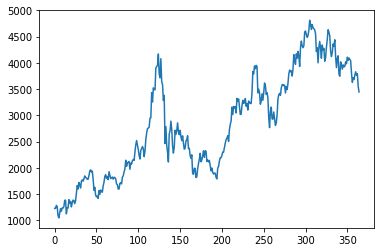

In [ ]:
#Plot the True Close Value
df['Close'].plot()

In [ ]:
#import pandas as pd

#Set Target Variable
output_var = pd.DataFrame(df['Close'])
#Selecting the Features
features = ['Open', 'High', 'Low', 'Volume']

**Scaling**

*To decrease the computational cost of the data in the table, we will scale the stock values to values between 0 and 1.* 


In [ ]:
#Scaling
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df[features])
feature_transform= pd.DataFrame(columns=features, data=feature_transform, index=df.index)
feature_transform.head()

,Open,High,Low,Volume
0,0.043633,0.039453,0.063937,0.410831
1,0.048383,0.037124,0.039851,0.462591
2,0.047792,0.045120,0.067846,0.313987
3,0.062961,0.056845,0.071127,0.412824
4,0.057850,0.033876,0.000000,0.682100


**Creating a Training Set and a Test Set for Crypto Market Prediction**

The LSTM model will be trained on the data in the training set and tested for accuracy and backpropagation on the test set.

We use 80% on training data, 10% validation set and 10% on test data


In [ ]:
#Splitting to Training set and Test set
timesplit= TimeSeriesSplit(n_splits=20)
for train_index, test_index in timesplit.split(feature_transform):
        X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()


In [ ]:
#!pip install sklearn
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

In [ ]:
#extract features and target variables
x = df.drop(columns="Close")
y = df["Close"]

# Defines ratios, w.r.t. whole dataset.
ratio_train = 0.8
ratio_val = 0.1
ratio_test = 0.1

# Produces test split.
x_remaining, x_test, y_remaining, y_test = train_test_split(
    x, y, test_size=ratio_test)

# Adjusts val ratio, w.r.t. remaining dataset.
ratio_remaining = 1 - ratio_test
ratio_val_adjusted = ratio_val / ratio_remaining

# Produces train and val splits.
x_train, x_val, y_train, y_val = train_test_split(
    x_remaining, y_remaining, test_size=ratio_val_adjusted)

Data preparation

We define a function which creates X inputs and Y labels for our model. In the sequential forecasting, we predict the future value based on some previous and current values. So, our Y label is the value from the next (future) point of time while the X inputs are one or several values from the past. The amount of these values we can set by tuning the parameter look_back in our function. If we set it to 1, this means that we predict current value t based on the previous value (t-1).





**Data Processing For LSTM**

The LSTM needs that the data to be provided in the 3D form, we first transform the training and test data to NumPy arrays and then restructure them to match into the format (Number of Samples, 1, Number of Features).The test set is reshaped.




In [ ]:
#Process the data for LSTM
trainX =np.array(X_train)
testX =np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
train=trainX.reshape(X_train.shape[0], 1, X_train.shape[1])

X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])
test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])


Building the LSTM Model for Prediction

 We build a Sequential Keras model with one LSTM layer. The LSTM layer has 32 units and is followed by one Dense Layer of one neuron.

We compile the model using Adam Optimizer and the Mean Squared Error as the loss function. For an LSTM model, this is the most preferred combination. 

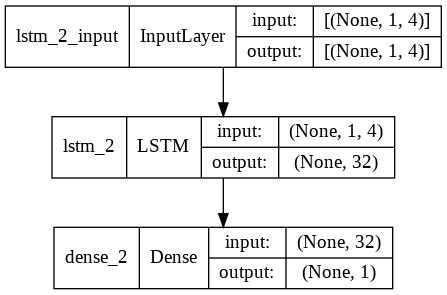

In [ ]:
#Building the LSTM Model
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')
plot_model(lstm, show_shapes=True, show_layer_names=True)

LSTM Prediction

we use the fit function to train the LSTM model created above on the training data for 100 epochs with a batch size of 8.



In [ ]:
#Model Training
history=lstm.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1, shuffle=False)


Epoch 1/100
42/42 [==============================] - 2s 3ms/step - loss: 8314218.5000
Epoch 2/100
42/42 [==============================] - 0s 3ms/step - loss: 8313270.0000
Epoch 3/100
42/42 [==============================] - 0s 3ms/step - loss: 8311699.5000
Epoch 4/100
42/42 [==============================] - 0s 3ms/step - loss: 8309374.5000
Epoch 5/100
42/42 [==============================] - 0s 3ms/step - loss: 8306062.5000
Epoch 6/100
42/42 [==============================] - 0s 3ms/step - loss: 8301555.5000
Epoch 7/100
42/42 [==============================] - 0s 3ms/step - loss: 8295698.5000
Epoch 8/100
42/42 [==============================] - 0s 3ms/step - loss: 8288398.0000
Epoch 9/100
42/42 [==============================] - 0s 5ms/step - loss: 8279617.0000
Epoch 10/100
42/42 [==============================] - 0s 5ms/step - loss: 8269363.5000
Epoch 11/100
42/42 [==============================] - 0s 4ms/step - loss: 8257686.5000
Epoch 12/100
42/42 [==============================] 

In [ ]:
#LSTM Prediction
#we can use it to forecast the Close Value of the Etherium stock by using a model trained using the LSTM network on the test set. 
#This is accomplished by employing the simple predict function on the LSTM model that has been created.

In [ ]:
y_pred= lstm.predict(X_test)

Comparing Predicted vs True Close Value – LSTM

Finally, now that we’ve projected the values for the test set, we can display the graph to compare both  Close’s true values and Close’s predicted value using the LSTM Machine Learning model.


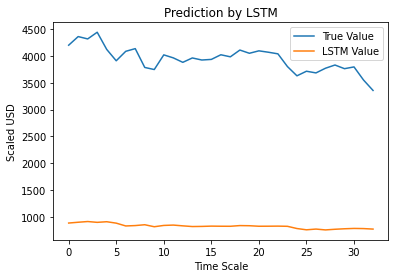

In [ ]:
#Predicted vs True Adj Close Value – LSTM
plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='LSTM Value')
plt.title("Prediction by LSTM")
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()